# Advanced Lane Finding

## Importing required packages

In [1]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
% matplotlib inline

## Camera Calibration

0. importing calibration images (chessboard images)
0. initiation of object and image points list
0. converting to grayscale
0. finding corners as imagepoints and appending object points (constant)
0. saving the resulting corner detection in an output folder over the original images
0. calibrate the opencv camera model using the object and image points
0. In order to test the model, we use the undistort function on a test image, not seen by calibration function, with the model gained above

In [2]:
# importing image address
chsbrd_cal_img_path = 'camera_cal'
chsbrd_output_img_path = 'camera_cal/out_put_corners'

cal_imgs = glob.glob(chsbrd_cal_img_path + '/calibration*.jpg')

# initiating object and image points list
obj_points = []
img_points = []
test_imgs_path = []

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

objp=np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


number_of_images_with_well_found_corners = 0
for img_path in cal_imgs:
    # import image
    cal_img = mpimg.imread(img_path)
    # convert to grayscale
    cal_img_gray = cv2.cvtColor(cal_img,cv2.COLOR_RGB2GRAY)
    """
    if images are not good enough or you made them from your monitor screen you will habe a lot of noise
    in the images (because of nature of monitor refresh you will have some noises in white areas) you 
    may want to filter images from and use it (without prining the chess board). In this case use the
    following filter and uncomment it:
    """
#     gray_editted = cv2.blur(cal_img_gray,(10,10))
#     gray_editted = (gray_editted>110)*255
#     cal_img_gray = 255-np.uint8(gray_editted)    
    
    # find corners
    ret, corners = cv2.findChessboardCorners(cal_img_gray,(nx,ny))
    
    # finding the name of the imported file and save the image with the same name in the other directory
    img_file_name = img_path.split('/')[-1].split('.')[0]
    if ret is True:
        number_of_images_with_well_found_corners += 1
        img_points.append(corners)
        obj_points.append(objp)
        # draw the corners on images and save it
        output_img = cv2.drawChessboardCorners(cal_img,(nx,ny),corners,ret)
        mpimg.imsave(chsbrd_output_img_path+'/'+img_file_name , output_img)
    else:
        print ('Corners of image {} are not found.'.format(img_file_name))
        test_imgs_path.append(img_path)

print('OpenCV found the corners of {} images from {} images'.
      format(number_of_images_with_well_found_corners,len(cal_imgs)))

Corners of image calibration1 are not found.
Corners of image calibration4 are not found.
Corners of image calibration5 are not found.
OpenCV found the corners of 17 images from 20 images


Corners of some of the images are not found because all corners were not inside the image or they were very close to the border of image. We can use these images to test the model to undistort and transform the chessboard for our model test algoritm.

In [3]:
# Calibrating camera using the obtained corners:
print('Calibrating the model')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, cal_img_gray.shape[::-1], None, None)
camera_to_save={"camera_matrix":mtx,"camera_distortion":dist}
pickle.dump( camera_to_save, open( "camera_model_param.p", "wb" ) )
print('Calibration is Done and camera Matrix & Distortion are saved')
print('Camera Matrix:', ' \n',mtx)
print('Distortion Parameters:', ' \n',dist)


Calibrating the model
Calibration is Done and camera Matrix & Distortion are saved
Camera Matrix:  
 [[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Distortion Parameters:  
 [[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259868]]


### Test the Calibration
0. demonstration of one of the images with found courners
0. undistorting and transforing the test images

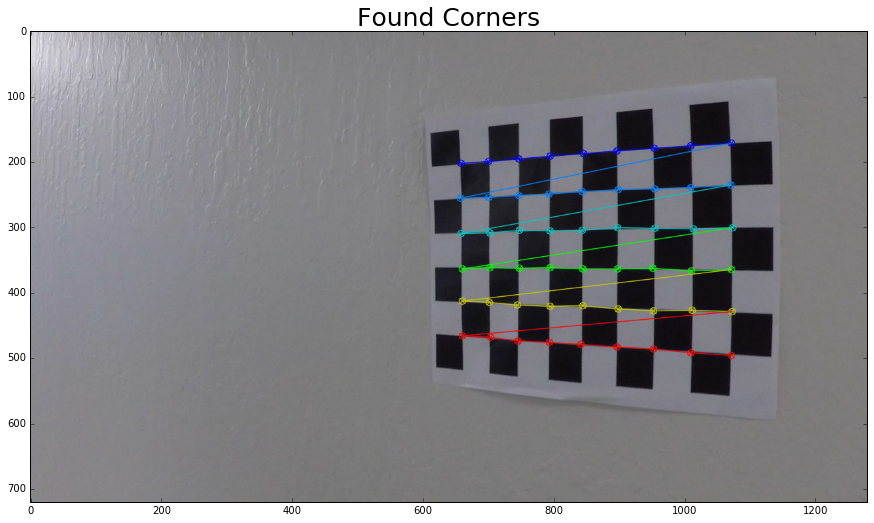

In [4]:
demo_img = mpimg.imread(chsbrd_output_img_path+'/calibration12')
plt.figure(figsize=(15,10))
plt.imshow(demo_img)
plt.title('Found Corners',fontsize=25)
plt.show()

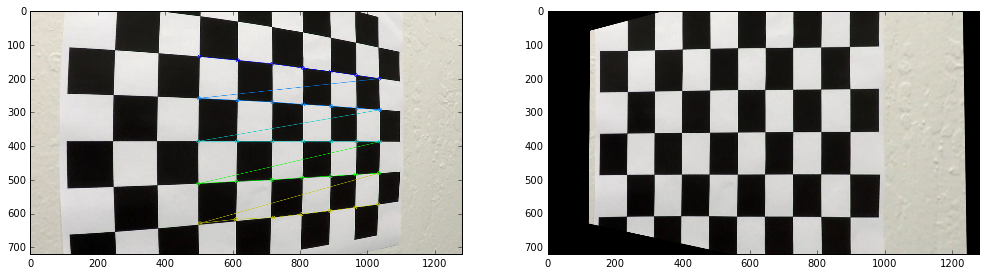

In [5]:
# undistoriting and transforming

def corners_unwarp(img_path, nx, ny,offsetx,offsety, mtx, dist):
    cal_img = mpimg.imread(img_path)
    heigth = cal_img.shape[0]
    width = cal_img.shape[1]
    # undistort image:
    img_undistorted = cv2.undistort(cal_img, mtx, dist, None, mtx)
    # convert to grayscale
    cal_img_gray = cv2.cvtColor(cal_img,cv2.COLOR_RGB2GRAY)
    # by changing these numbers, the opencv will find some on test images
    ret, corners = cv2.findChessboardCorners(cal_img_gray,(nx,ny),None)
    if ret is True:
        output_img_with_corners = cv2.drawChessboardCorners(cal_img,(nx,ny),corners,ret)
        src = np.float32([
            np.squeeze(corners[0]),
            np.squeeze(corners[nx-1]),
            np.squeeze(corners[nx*(ny-1)]),
            np.squeeze(corners[nx*ny-1])
            ])
        dst = np.float32([
            [offsetx,offsety],
            [width-offsetx,offsety],
            [offsetx,heigth-offsety],
            [width-offsetx,heigth-offsety]
        ])
        M = cv2.getPerspectiveTransform(src,dst)
        img_size = (width,heigth)
        warped = cv2.warpPerspective(img_undistorted, M, img_size, flags=cv2.INTER_LINEAR)
        plt.figure(figsize=(17,8))
        plt.subplot(121)
        plt.imshow(output_img_with_corners)
        plt.subplot(122)
        plt.imshow(warped)
        plt.show()

for img_path in test_imgs_path:
    corners_unwarp(img_path, nx-2, ny-1,400,120, mtx, dist)

## Main pipline:
Now having the calibrated model of image, a pipeline should be design that is working for at least one frame and then later will be applied for a video. The pipeline should include:
0. Camera Calibration (which is done above)
0. Distortion correction on road image
0. Perspective Transform to get a bird-eye view of the road (simply top view of the road)
0. Color and Gradient thresholing to find a rough place of lanes
0. Fine tunning the previous methof using the sliding window and histogram
0. Find curvature equation

In [2]:
def get_camera_para ():
    """
    loads the camera model parameter and returns two arrays
    camera matrix and camera distortion parameters
    """
    camera_model = pickle.load( open( "camera_model_param.p", "rb" ) )
    return camera_model["camera_matrix"],camera_model["camera_distortion"]


def undistor_img(img, mtx, dist):
    img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return img_undistorted

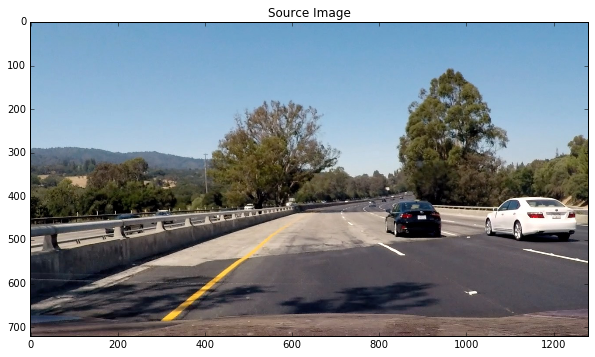

In [3]:
test_imgs_path = 'test_images'
test_imgs_path = glob.glob(test_imgs_path+'/*.jpg',)
mtx,dist = get_camera_para()
test_img_idx = 5
test_img = mpimg.imread(test_imgs_path[test_img_idx])

plt.figure(figsize=(10,8))
plt.imshow(test_img)
plt.title('Source Image')
plt.show()

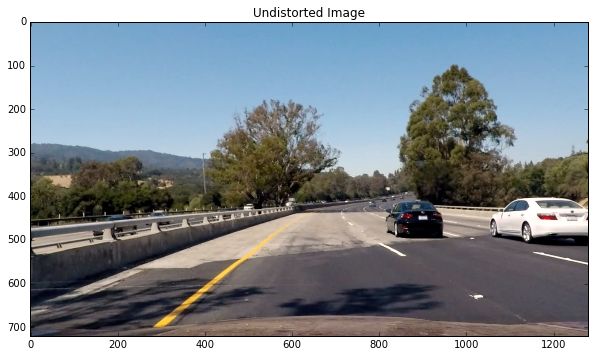

In [4]:
# undistort image
img_undistorted = undistor_img(test_img,mtx,dist)
plt.figure(figsize=(10,8))
plt.imshow(img_undistorted)
plt.title('Undistorted Image')
plt.show()

### Color and Gradient Thresholding
0. Colorspace conversion
0. Gradiant & thresholding
0. Angle & thresholding

In [5]:
def thresholding (arr,thresh):
    """
    General thresholding
    """
    binary_out = np.zeros_like(arr)
    binary_out[(arr>thresh[0])&(arr<=thresh[1])]=1
    return binary_out

def abs_sobel_thresh(channel,sobel_kernel = 3, orient='x', thresh=(0,255)):
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient is 'x':
        sobel_img = cv2.Sobel(channel, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    else:
        sobel_img = cv2.Sobel(channel, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # Take the absolute value of the derivative or gradient
    sobel_abs = np.absolute(sobel_img)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel_scaled = np.uint8(255*sobel_abs/np.max(sobel_abs))
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_img = thresholding(sobel_scaled,thresh)
    # 6) Return this mask as your binary_output image
    return binary_img

def mag_sobel_thresh(channel, sobel_kernel=3, thresh=(0, 255)):
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # Calculate the magnitude 
    abs_sobel = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a binary mask where mag thresholds are met
    binary_img = thresholding(scaled_sobel,thresh)
    # Return this mask as your binary_output image
    return binary_img

def dir_sobel_thresh(channel, sobel_kernel=3, thresh=(-np.pi/2, np.pi/2)):
    #  Take the gradient in x and y separately
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(np.power(sobelx,2))
    abs_sobely = np.sqrt(np.power(sobely,2))
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    angle = np.arctan2(abs_sobely, abs_sobelx)
    angle = np.absolute(angle)
    # Create a binary mask where direction thresholds are met
    binary_output = thresholding(angle,thresh)
    # Return this mask as your binary_output image
    return binary_output

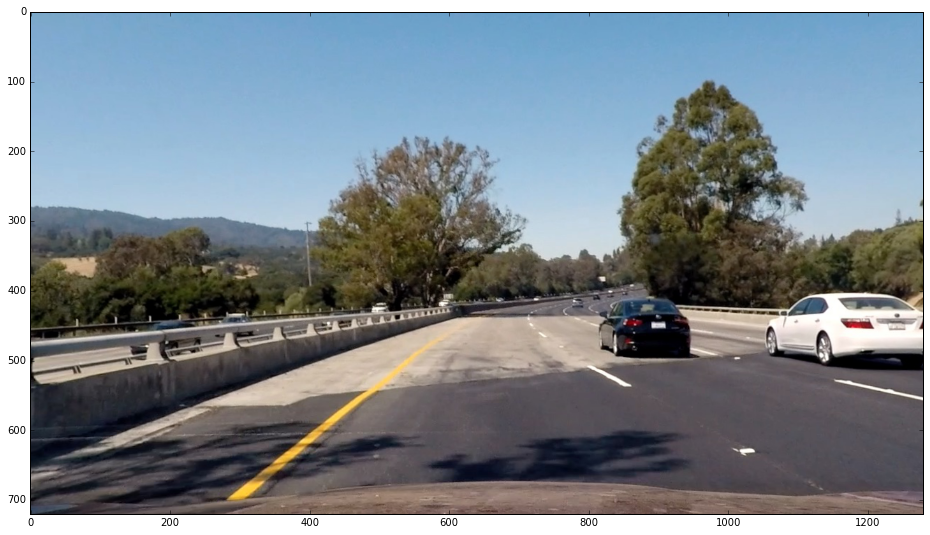

In [6]:
# conda install pyqt=4
# inline
%matplotlib qt 
test_img = mpimg.imread(test_imgs_path[5])
#undistort
img_undistorted = undistor_img(test_img,mtx,dist)
# exctract S channel
hls_img = cv2.cvtColor(img_undistorted,cv2.COLOR_RGB2HLS)
l_channel = hls_img[:,:,1]
s_channel = hls_img[:,:,2]

#sobell test
sobel_thresh = abs_sobel_thresh(s_channel, sobel_kernel=3,orient='x',thresh=(20,255))
# sobel mag test
sobel_mag = mag_sobel_thresh(s_channel, sobel_kernel=3,thresh=(30, 100) )
# dir test
sobel_dir = dir_sobel_thresh(s_channel, sobel_kernel=3,thresh=(np.deg2rad(40),np.deg2rad(70) ) )
# combine
combined_image = np.logical_and(sobel_thresh,np.logical_and(sobel_mag,sobel_dir))

# plt.figure(figsize=(16,14))
# plt.subplot(321)
# plt.imshow(img_undistorted)
# plt.title('undistorted image')
# plt.subplot(322)
# plt.imshow(sobel_thresh,cmap='gray')
# plt.title('Sobel')
# plt.subplot(323)
# plt.imshow(sobel_mag,cmap='gray')
# plt.title('Sobel mag')
# plt.subplot(324)
# plt.imshow(sobel_dir,cmap='gray')
# plt.title('sobel dir')
# plt.subplot(325)
# plt.imshow(combined_image,cmap='gray')
# plt.title('combined')
plt.figure(figsize=(16,14))
plt.imshow(img_undistorted)
plt.show()

todo :
0. write general function to apply filter to all iimages
0. play more with filters and gradiants and more

In [7]:
# transformation
# src = np.float32([[213,705],[1074,692],[667,435],[614,435]])
# dst_small = np.float32([[213,705],[1074,692],[1076,0],[213,0]])
# src line equation for transformation
left_points_x = np.float32([213,614])
left_points_y = np.float32([705,435])

right_points_x = np.float32([1074,667])
right_points_y = np.float32([692,435])

left_line_trans = np.polyfit(left_points_y,left_points_x,1)
right_line_trans = np.polyfit(right_points_y,right_points_x,1)

In [17]:
# transformation
%matplotlib inline
def transform(img_undistorted,left_line_trans,right_line_trans):
    
    src_size = (img_undistorted.shape[1],img_undistorted.shape[0])
    dst_size = (int(img_undistorted.shape[1]*1.2),int(img_undistorted.shape[0]))

    mid_x_src = src_size[0] / 2
    mid_x_dst = dst_size[0] / 2

    y2 = 705
    y1 = 460
    src = np.float32([[np.polyval(left_line_trans,y2),y2],
                      [np.polyval(right_line_trans,y2),y2],
                      [np.polyval(right_line_trans,y1),y1],
                      [np.polyval(left_line_trans,y1),y1]])

    dst=np.float32([[mid_x_dst - (mid_x_src - src[0,0]) , dst_size[1]-(src_size[1]-src[0,1])],
         [mid_x_dst - (mid_x_src - src[1,0]) , dst_size[1]-(src_size[1]-src[1,1])],
         [mid_x_dst - (mid_x_src - src[1,0]) , dst_size[1]-(src_size[1]-0)],
         [mid_x_dst - (mid_x_src - src[0,0]) , dst_size[1]-(src_size[1]-0)]])

    M = cv2.getPerspectiveTransform(src,dst)
    
    img_undistorted_with_polygon = img_undistorted.copy()
    cv2.polylines(img_undistorted_with_polygon, np.int32([src]),True,[255,0,0],5)

    warped = cv2.warpPerspective(img_undistorted, M, dst_size, flags=cv2.INTER_LINEAR)
    return warped,img_undistorted_with_polygon

def grad_thresholding (warped_image,
                       sobel_x_thresh=(40,255),
                       sobel_mag_thresh=(20, 255),
                       dir_thresh=(np.deg2rad(0),np.deg2rad(20))):
    
    hls_img = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)
    l_channel = hls_img[:,:,1]
    s_channel = hls_img[:,:,2]

    #sobell test
    sobel_thresh = abs_sobel_thresh(s_channel, sobel_kernel=3,orient='x',thresh=sobel_x_thresh)
    # sobel mag test
    sobel_mag = mag_sobel_thresh(s_channel, sobel_kernel=3,thresh=sobel_mag_thresh )
    # dir test
    sobel_dir = dir_sobel_thresh(s_channel, sobel_kernel=3,thresh=(np.deg2rad(0),np.deg2rad(20) ) )
    # combine
    combined_image = np.logical_and(np.logical_and(sobel_thresh,sobel_dir),sobel_mag)
    return sobel_thresh, sobel_mag, sobel_dir, combined_image

def histogram_peak_detection(img):
    histo = np.sum(img[int(img.shape[0]*2/5):,:], axis=0)
    mid_point = int(histo.shape[0]/2)
    left_peak = np.argmax(histo[:mid_point])
    right_peak = np.argmax(histo[mid_point:]) + mid_point
    return histo,left_peak,right_peak

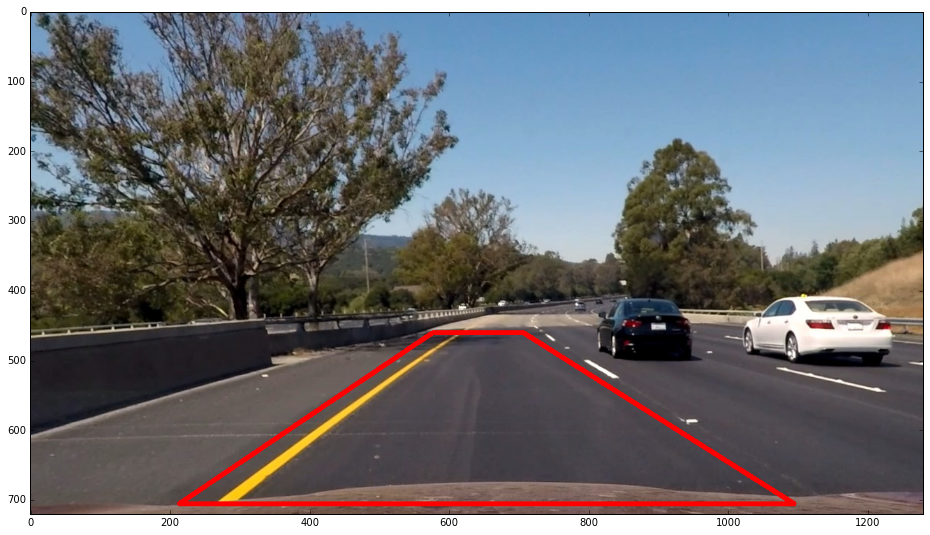

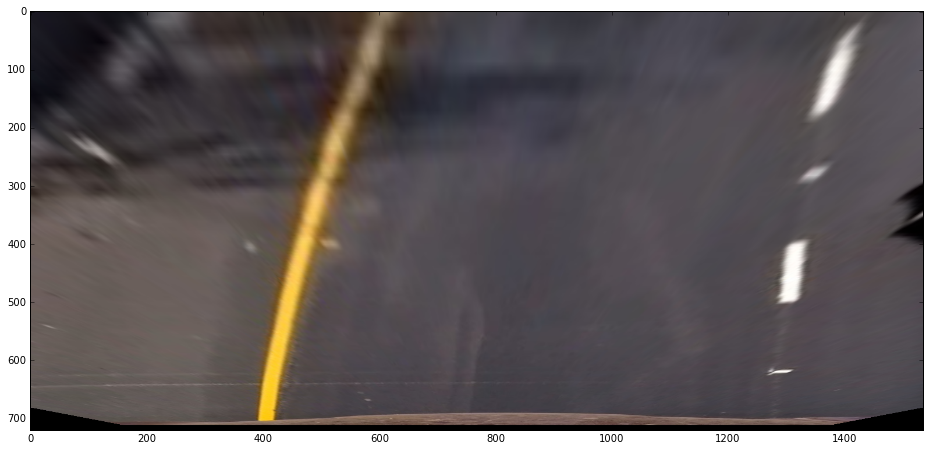

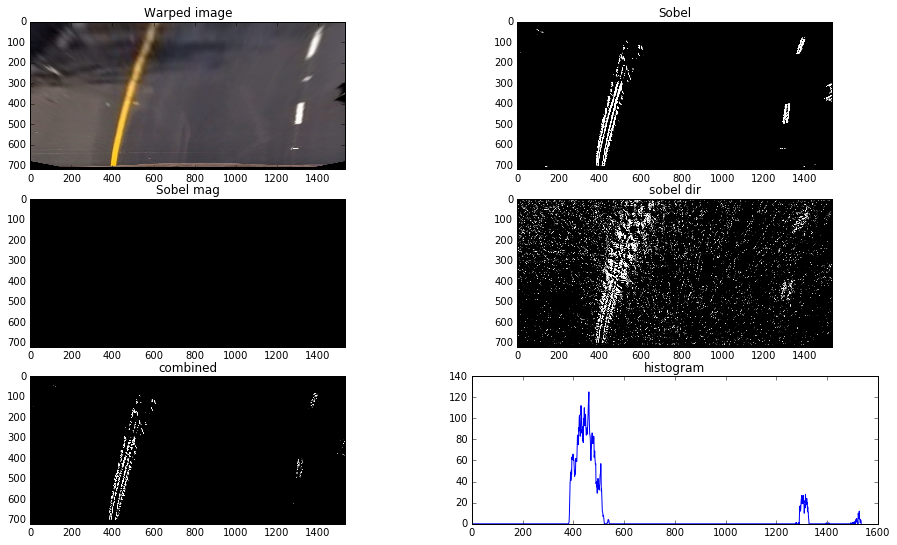

In [18]:
test_img = mpimg.imread(test_imgs_path[7])
img_undistorted = undistor_img(test_img,mtx,dist)
warped,img_undistorted_with_polygon = transform(img_undistorted,left_line_trans,right_line_trans)
sobel_thresh, sobel_mag, sobel_dir, combined_image = grad_thresholding(
    warped,
    sobel_x_thresh=(10,255),
    sobel_mag_thresh=(-1, 300),
    dir_thresh=(np.deg2rad(0),np.deg2rad(20)))

hist,le,ri = histogram_peak_detection(combined_image)
plt.figure(figsize=(16,10))
plt.imshow(img_undistorted_with_polygon)
plt.figure(figsize=(16,10))
plt.imshow(warped)

plt.figure(figsize=(16,9))
plt.subplot(321)
plt.imshow(warped)
plt.title('Warped image')
plt.subplot(322)
plt.imshow(sobel_thresh,cmap='gray')
plt.title('Sobel')
plt.subplot(323)
plt.imshow(sobel_mag,cmap='gray')
plt.title('Sobel mag')
plt.subplot(324)
plt.imshow(sobel_dir,cmap='gray')
plt.title('sobel dir')
plt.subplot(325)
plt.imshow(combined_image,cmap='gray')
plt.title('combined')
plt.subplot(326)
plt.plot(hist)
plt.title('histogram')
plt.show()

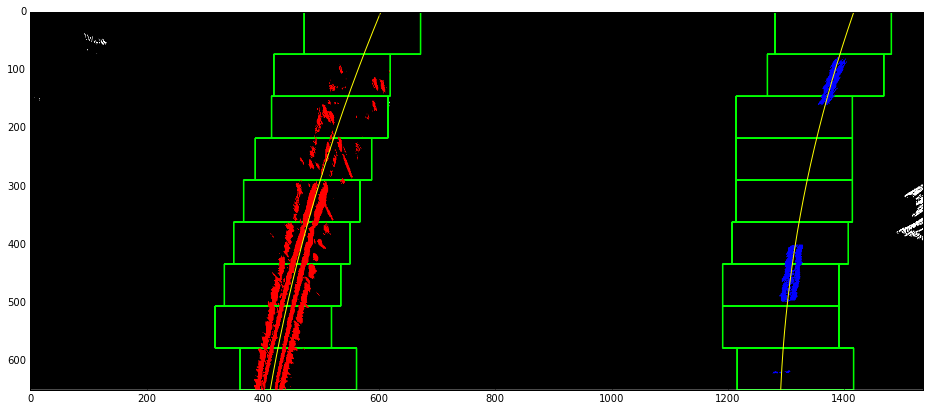

In [30]:
binary_warped = sobel_thresh[:650,:]
leftx_base = le
rightx_base = ri

# sliding windows
nwindows = 9
window_height = np.int(binary_warped.shape[0]/nwindows)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) &
                      (nonzeroy < win_y_high) &
                      (nonzerox >= win_xleft_low) &
                      (nonzerox < win_xleft_high)).nonzero()[0]
    
    good_right_inds = ((nonzeroy >= win_y_low) &
                       (nonzeroy < win_y_high) &
                       (nonzerox >= win_xright_low) &
                       (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.figure(figsize=(16,10))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, binary_warped.shape[1])
plt.ylim(binary_warped.shape[0], 0)
plt.show()